# Problem5 Inverse Ising model and graph reconsruction

In the section we are interested in graph recosntruction providing data D of M different valid (in the MCMC algorithm) spins configurations of N vertices.

First we are going to build the data D. 

In [148]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random as rdm

In [149]:
#Degree Probability distribution
def degree(pi_p):
    if rdm.random() < (1-pi_p):
        return 1
    else:
        return 4

In [150]:
# excess degree dstribution
def q_d(pi_p):
    if rdm.random() < (1-pi_p)/(1+3*pi_p):
        return 0
    else:
        return 3

In [151]:
# definition of a function that will create the graph
def Graph(N_p,pi_p):
    c=False
    while c==False:
        K=[]
        for i in range(N_p):
            K.append(degree(pi_p)) #Creation of the list of all degrees
        if sum(K)%2 == 0:
            c=True
    
    Gr = nx.configuration_model(K)
    return Gr

In [152]:
def DeltaE(v_p,S_p,G_p):
    return  2*S_p[v_p]*sum(S_p[i] for i in G_p[v_p])

Let's set all the parameters to generate our graph : it won't change after that. 

In [153]:
N = 1000
M = 300
pi = 0.9
T =  5
G = Graph(N,pi)
nstep = 100000
D = np.zeros( (M,N) )

In [154]:
for d in range(M):
    S = [rdm.choice([1,-1]) for i in range(N)]
    for k in range(nstep):
        v = rdm.randint(0,N-1)# pick randomly a spin
        if DeltaE(v,S,G) > 0:
            if rdm.uniform(0,1) < np.exp(-DeltaE(v,S,G)/T):
                S[v] *= -1 # change the configuration 
        else:
            S[v]*=-1
    D[d,:]=S

With the data matrix D we can compute the connected correlations $C_{ij} = \langle s_is_j \rangle - \langle s_i \rangle \langle s_j \rangle $

One can also compute the Person correlation $C_p$ but we won't use it afterwards.

In [155]:
C = np.zeros( (N,N) )
#Cp = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        C[i,j] = np.mean( (D[:,i] - np.mean(D[:,i])) * (D[:,j] - np.mean(D[:,j]) ) )
        
#for i in range(N):
    #for j in range(N):
        #Cp[i,j] = C[i,j]/np.sqrt(C[i,i]*C[j,j])

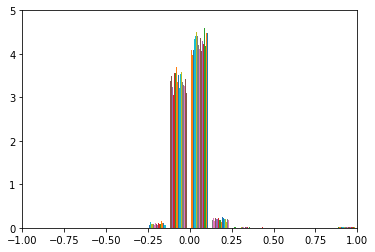

In [172]:
plt.hist(C,normed=True)
plt.axis([-1,1,0,5])
plt.savefig('hist_C.png')
plt.show()

Result can be seen here : ![hist_C](hist_C.png)

One can now guess the graph generated G attributing an edge for each correlation $C_{ij}$ non zero. 

In practice, the histogram show that many most of the correlations are close to zero. One need to take a value $C^*$ such that an edge will be created if the $C_{ij} > C^*$ . Let's take $C^* = 0.35$

We create a list of all edges in our predicted graph : $L_{edges}$

In [159]:
L_edges = []
for i in range(N):
    for j in range(N):
        if abs(C[i,j]) > 0.35 and j!=i:
            L_edges.append((i,j))
        else:
            continue

We ca look at how good we performed : the result r if the ratio betwenn the number of truely detected edge and the total number of detected edges. 

In [162]:
r=0
for i,j in L_edges:
    if (i,j) in G.edges():
        r+=1
print(r/len(L_edges),r,len(L_edges))

1.0 18 18


For a this value of $C^*$ we found 18 edges (very little) but they are all in the real graph. Let's try to guess more edges, obviously this ratio r will decrease at a certain point. 

In [168]:
L_edges = []
for i in range(N):
    for j in range(N):
        if abs(C[i,j]) > 0.25 and j!=i:
            L_edges.append((i,j))
        else:
            continue
r=0
for i,j in L_edges:
    if (i,j) in G.edges():
        r+=1
print(r/len(L_edges),r,len(L_edges),len(G.edges()))

0.9858356940509915 696 706 1838


Here we found 696 good edges on 706 in total. let's recall that the real graph has 1838 edges. Not that bad, but can still be improved. 
The value of  $C^*$ at which r is not 1 anymore is 0.28.


Let's look at the mean field approach. First we are going to compute the frequencies $f_i(s) = \dfrac{1}{M}\sum_m \delta_{s,s_i^m}$ and $f_{ij}(s,t) = \dfrac{1}{M} \sum_m  \delta_{s,s_i^m}\delta_{t,s_j^m}$ with s and t being -1 or +1 (which give a matrix size of NxNx2x2)

In [169]:
f = np.zeros((N,2))
ff = np.zeros((N,N,2,2))

for i in range(N):
    for m in range(M):
        if D[m,i] == 1:
            f[i,1] += 1
        else:
            f[i,0] += 1
f=f/M

for i in range(N):
    for j in range(N):
        for m in range(M):
            if D[m,i] == 1 and D[m,j] == 1:
                ff[i,j,1,1] += 1
            elif D[m,i] == -1 and D[m,j] == 1:
                ff[i,j,0,1] += 1
            elif D[m,i] == 1 and D[m,j] == -1:
                ff[i,j,1,0] += 1
            else:
                ff[i,j,0,0] += 1
ff = ff/M

In [170]:
C_mf = np.zeros((N,N,2,2))
for s,t in [(1,1),(0,1),(1,0),(0,0)]:
    for i in range(N):
        for j in range(N):
            C_mf[i,j,s,t] = ff[i,j,s,t] - f[i,s]*f[j,t]

We can also compute the coupling parameter $J_{ij}$

In [171]:
J = np.zeros((N,N,2,2))
for s,t in [(1,1),(0,1),(1,0),(0,0)]:
    J[:,:,s,t] = - np.linalg.inv(C_mf[:,:,s,t])

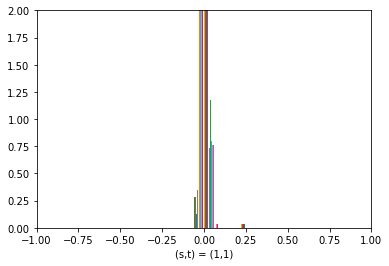

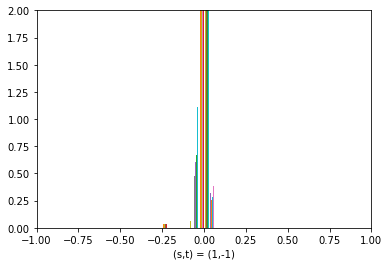

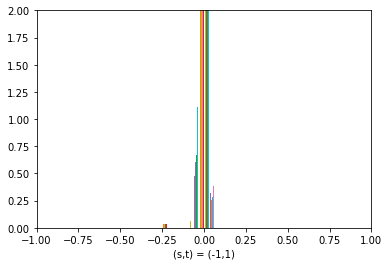

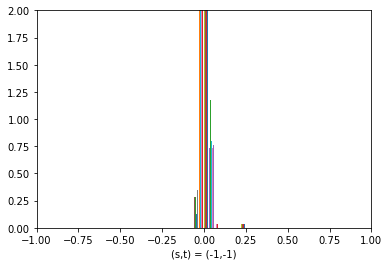

In [177]:
plt.hist(C_mf[:,:,1,1],normed=True)
plt.axis([-1,1,0,2])
plt.xlabel('(s,t) = (1,1)')
plt.savefig('hist_C(1,1.png')
plt.show()

plt.hist(C_mf[:,:,1,0],normed=True)
plt.axis([-1,1,0,2])
plt.xlabel('(s,t) = (1,-1)')
plt.savefig('hist_C(1,-1).png')
plt.show()

plt.hist(C_mf[:,:,0,1],normed=True)
plt.axis([-1,1,0,2])
plt.xlabel('(s,t) = (-1,1)')
plt.savefig('hist_C(-1,1).png')
plt.show()

plt.hist(C_mf[:,:,0,0],normed=True)
plt.axis([-1,1,0,2])
plt.xlabel('(s,t) = (-1,-1)')
plt.savefig('hist_C(-1,-1).png')
plt.show()

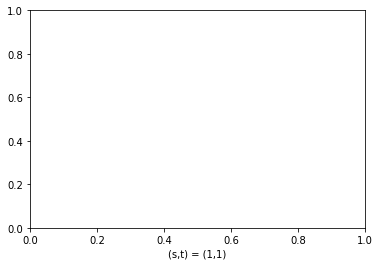

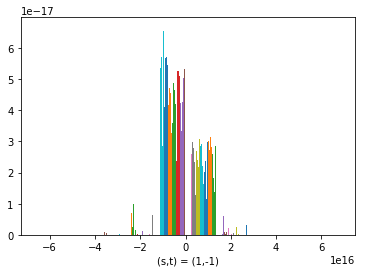

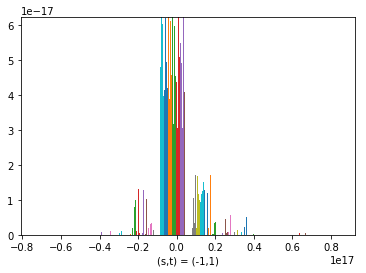

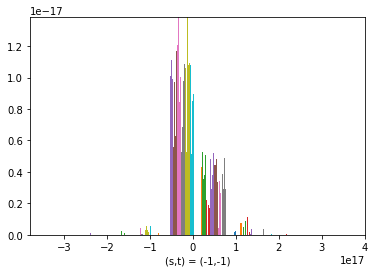

In [181]:
plt.hist(J[:,:,1,1],normed=True)
plt.xlabel('(s,t) = (1,1)')
plt.savefig('hist_J(1,1).png')
plt.show()

plt.hist(J[:,:,1,0],normed=True)
plt.xlabel('(s,t) = (1,-1)')
plt.savefig('hist_J(1,-1).png')
plt.show()

plt.hist(J[:,:,0,1],normed=True)
plt.xlabel('(s,t) = (-1,1)')
plt.savefig('hist_J(-1,1).png')
plt.show()

plt.hist(J[:,:,0,0],normed=True)
plt.xlabel('(s,t) = (-1,-1)')
plt.savefig('hist_J(-1,-1).png')
plt.show()

We can look at the coupling for the edges in the real graph : 

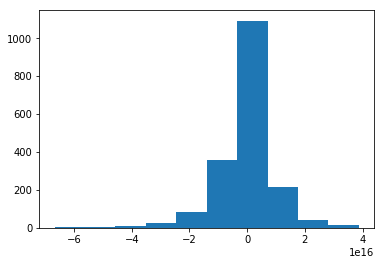

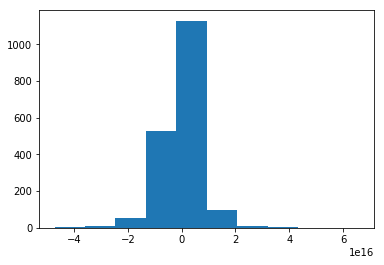

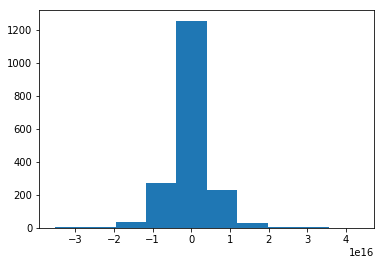

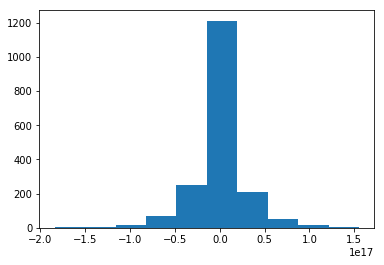

In [185]:
for s,t in [(1,1),(0,1),(1,0),(0,0)]:
    J_coupling = []
    for i,j in G.edges():
        J_coupling.append(J[i,j,s,t])
        tlt = str((s,t))
    plt.hist(J_coupling,label=tlt)
    plt.show()

And the coupling for the edges not in the graph : 

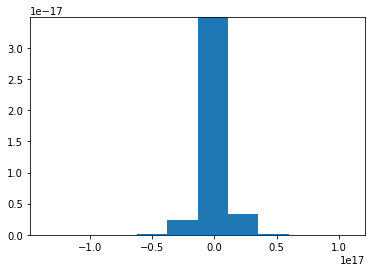

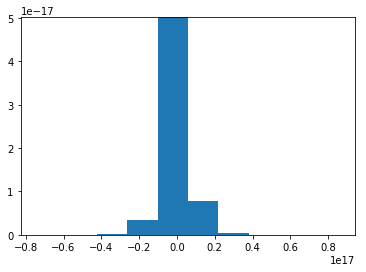

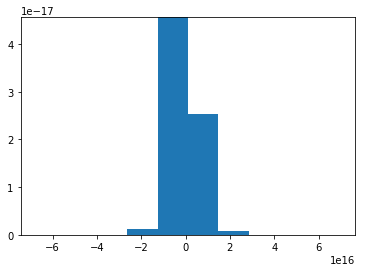

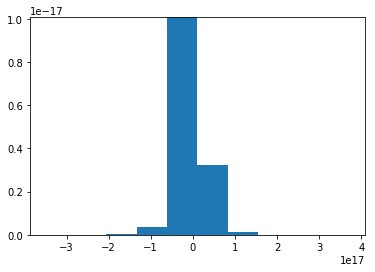

In [190]:
for s,t in [(1,1),(0,1),(1,0),(0,0)]:
    J_coupling = []
    for i in range(N):
        for j in range(N):
            if (i,j) is not G.edges():
                J_coupling.append(J[i,j,s,t])
    tlt = str((s,t))
    plt.hist(J_coupling,normed=True,label=tlt)
    plt.show()